# Section entry point instrumentation: QA and overview of aggregate data 
**Last Updated**: 25 October 2022

[Task](https://phabricator.wikimedia.org/T295757) | [Codebase](https://gitlab.wikimedia.org/mneisler/content_translation_workflow_research_2022)



# Data

Data comes from the [content_translation_event](https://github.com/wikimedia/schemas-event-secondary/tree/master/jsonschema/analytics/mediawiki/content_translation_event) instrument, which was designed to collect data on all the user-facing aspects of the Content Translation tool including the various entry points. 

Data reflects all events logged from 09 September 2022 (when events were logged as expected) through 20 September 2022.

All `dashboard_open` and `dashboard_translation_start` events should be logged as follows:
* [Recent translation entry point](https://phabricator.wikimedia.org/T287236): event_source = recent_translation (Done)
  * Description: A notice on recently translated articles that invites users to review and expand with the translation of a new section.
  * Available: Logged-In Mobile Users
* [Mobile language selector entry point](https://phabricator.wikimedia.org/T292828): event_source = content_language_selector (DONE)
  * Description: Logged-in users on mobile. The language links shown when a user searches for a language where the article is not available in and where mobile translation is supported as an invitation to translate. Note: On desktop, this is a source for the editor_open event as it opens the editor directly without an intermediate stop on the dashboard.
  * Available on desktop and mobile
* [Missing frequent langagues entry point](https://phabricator.wikimedia.org/T298032): event_source = frequent_languages (DONE)
  * Description: An indicator in the "Suggested Languages" section of the language selector that surfaces frequently-accessed missing languages as an opportunity to translate them.
  * Available in Desktop and mobile
* [Recent edit](https://phabricator.wikimedia.org/T287025?useskin=vector-2022) event_source = recent_edit
  * Description: On mobile, the user is in a page that they have edited in another language recently in their 10 latest significant edits (+500 bytes or more) for a section missing in the current language.
  * Available: Mobile
* [Creating a new article on mobile entry point](https://phabricator.wikimedia.org/T298084): event_source = invite_new_article_creation
  * Description: If there is a relevant suggestion based on the title it is shown in the invite. Otherwise, the invite is shown only once for the user.
  * Available: Desktop and Mobile Users

Please see phab tasks below for additional details:
* [Instrumentation of new SX entry points](https://phabricator.wikimedia.org/T301222)
* [Instrument mobile langauge selector entry point](https://phabricator.wikimedia.org/T290428)
* [Entry Point Documentation](https://www.mediawiki.org/wiki/Help:Content_translation/Starting?useskin=vector-2022#Invites_to_translate)





In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse)
    library(lubridate)
    library(ggrepel)
})

In [72]:
library(dplyr, warn.conflicts = FALSE)

# Suppress summarise info
options(dplyr.summarise.inform = FALSE)

In [2]:
query <- 
"SELECT 
date_format(dt, 'yyyy-MM-dd') AS `date`,
web_session_id,
web_pageview_id,
content_translation_session_id,
content_translation_session_position,
wiki_db,
user_is_anonymous,
user_global_edit_count,
user_global_edit_count_bucket,
translation_type,
translation_target_language,
translation_source_language,
utm_campaign,
user_name,
event_type,
event_source,
access_method
FROM 
event.mediawiki_content_translation_event
WHERE
YEAR = 2022 
AND MONTH = 09 
AND Day >= 09--deployment of all instrumentation points
"

In [3]:
sx_entry_events <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [4]:
# set event entry factor levels

sx_entry_events$event_source = factor(sx_entry_events$event_source,
                             levels = c('frequent_languages', 'content_language_selector', 'direct', 
                                        'invite_new_article_creation', 'direct_preselect'))


In [5]:
# set global edit count factor levels
sx_entry_events$user_global_edit_count_bucket = factor(sx_entry_events$user_global_edit_count_bucket,
                             levels = c('0 edits', '1-4 edits', '5-99 edits', 
                                        '100-999 edits', '1000+ edits'))

In [6]:
# convert to date

sx_entry_events$date <- as.Date(sx_entry_events$date, format = "%Y-%m-%d")

# Overall Events

In [73]:
sx_entry_events_bytype <- sx_entry_events %>% 
    group_by(event_source) %>%
    summarise(n_events = n(),
             n_users = n_distinct(user_name)) %>%
     mutate(pct_events = round(n_events / sum(n_events), 3)) %>%
    arrange(desc(n_events))

sx_entry_events_bytype

event_source                n_events n_users pct_events
1 frequent_languages          11799    3444    0.677     
2 content_language_selector    2831     708    0.162     
3 direct                       1828     713    0.105     
4 invite_new_article_creation   521      84    0.030     
5 direct_preselect              450      86    0.026     
6 NA                              4       2    0.000

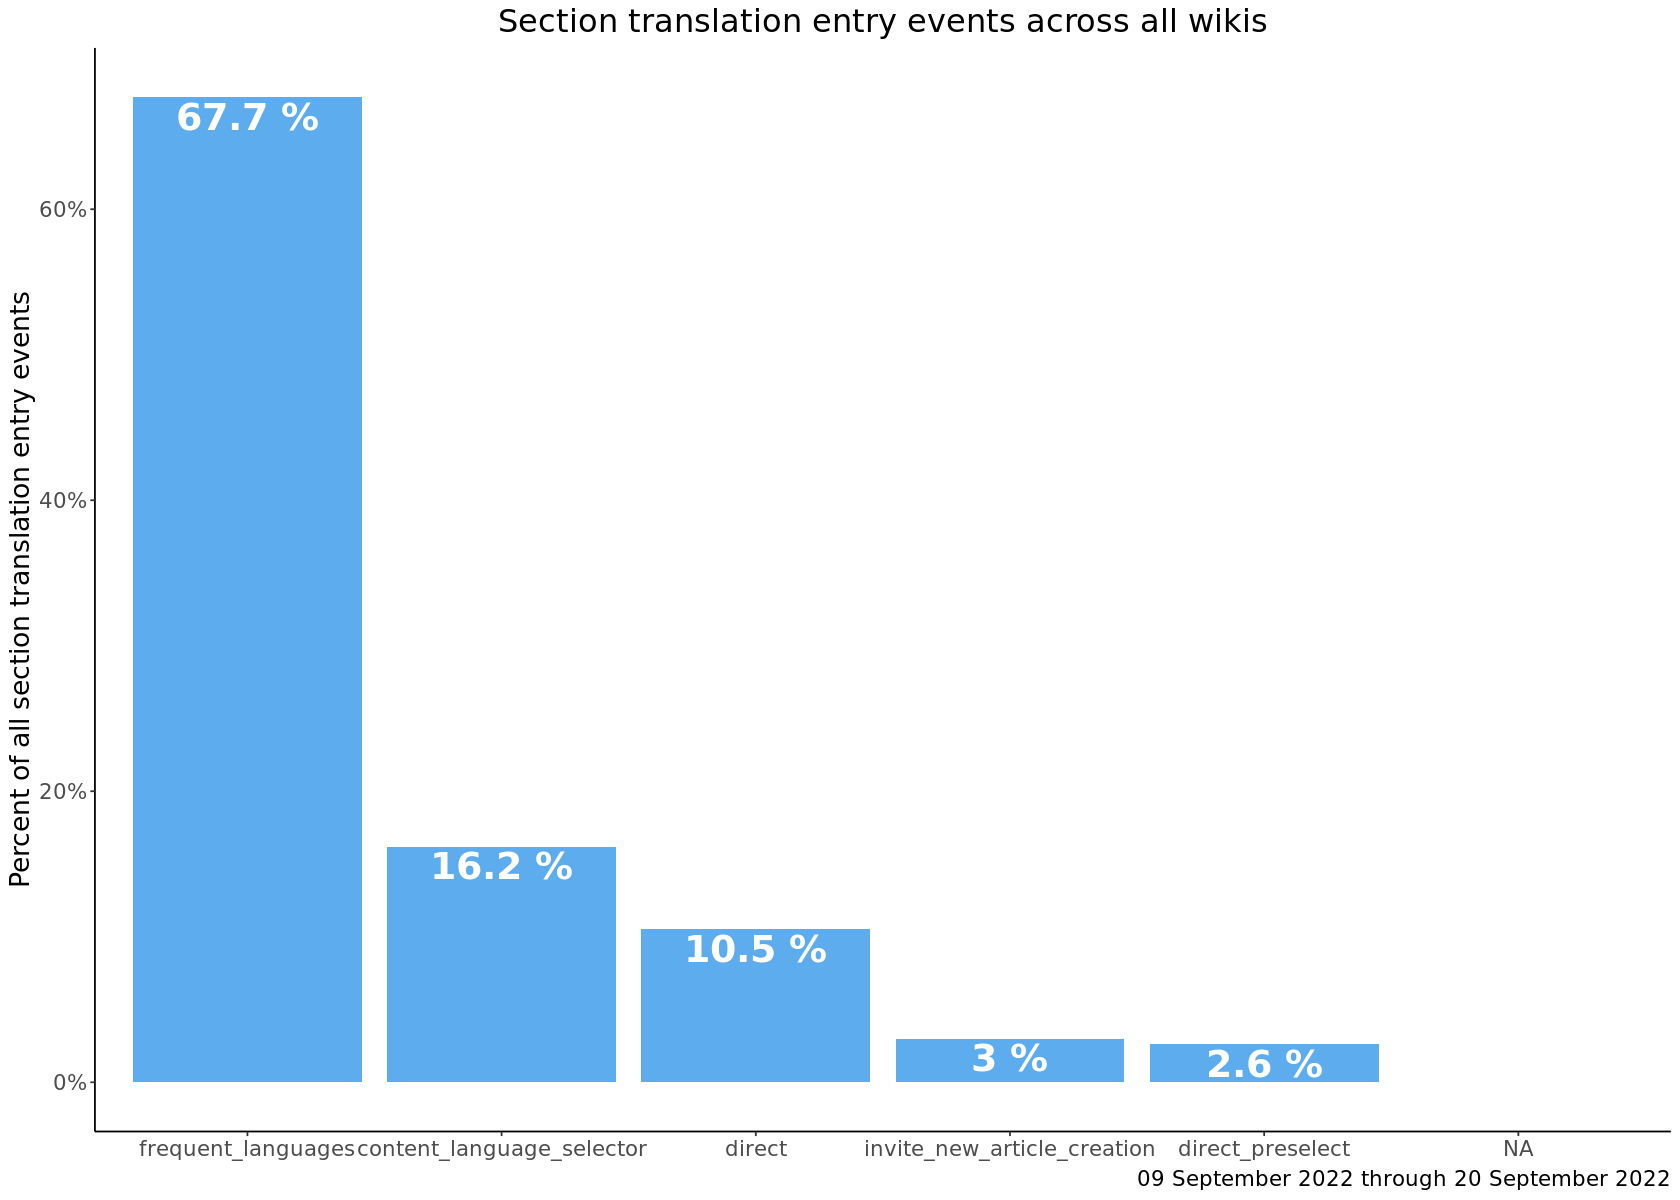

In [8]:
# plot frequency of events by type
options(repr.plot.width = 14, repr.plot.height = 10)

p <- sx_entry_events_bytype  %>%
    ggplot(aes(x= event_source, y = pct_events)) +
    geom_col(position = 'dodge', fill = 'steelblue2') +
    geom_text(aes(label = paste(pct_events * 100, "%")), fontface=2, vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of all section translation entry events",
          title = "Section translation entry events across all wikis",
         caption = "09 September 2022 through 20 September 2022")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        axis.title.x=element_blank(),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/sx_entry_events_bytype.png", p, width = 16, height = 8, units = "in", dpi = 300)

The `frequent_languages` entry point has been the most used entry point (68% of all instrumented section translation entry point clicks from 09 September through 20 September 2022).

# Overall Daily Events

In [9]:
# collect section entry point events
sx_entry_events_bytype_daily <- sx_entry_events %>% 
group_by(date, event_source) %>%
summarise(n_events = n())



`summarise()` regrouping output by 'date' (override with `.groups` argument)



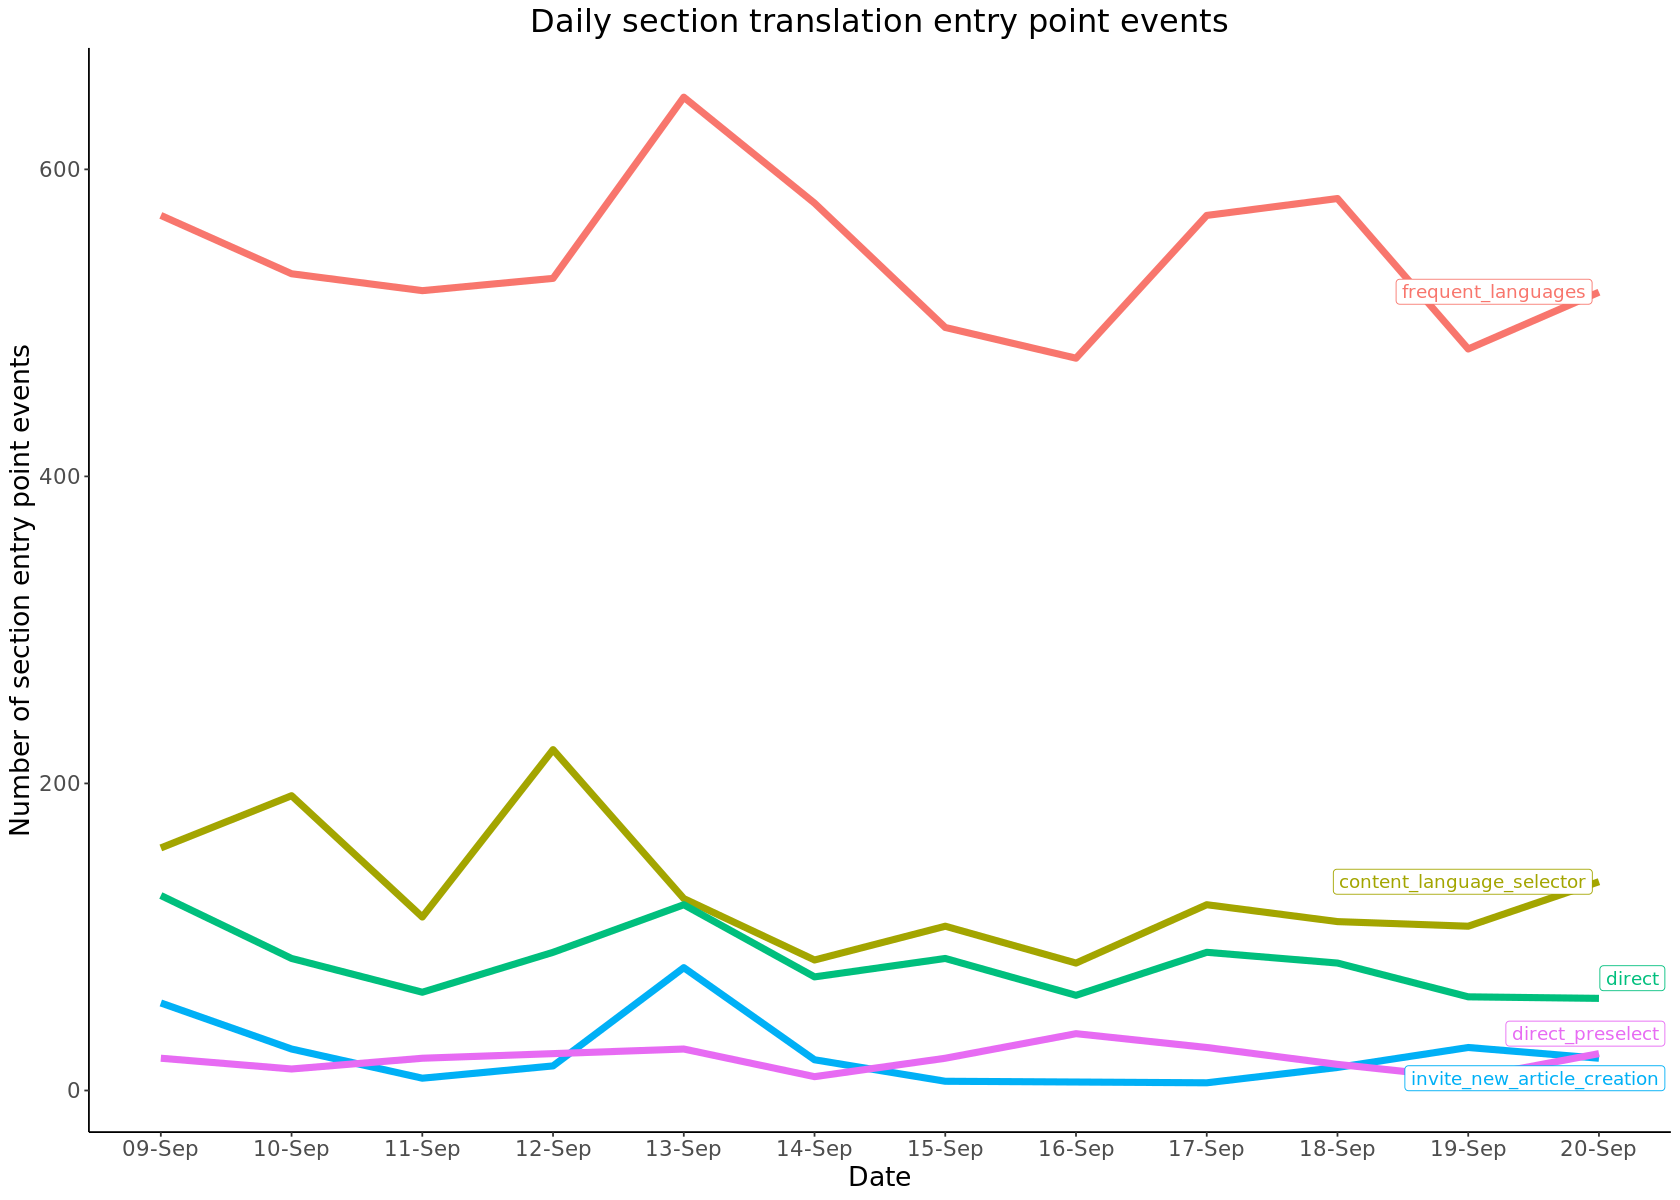

In [10]:
p <- sx_entry_events_bytype_daily %>%
    mutate(label = if_else(date == '2022-09-20', as.character(event_source), NA_character_)) %>%
    filter(date >= '2022-09-09' &
          date <= '2022-09-20')  %>% #remove days with incomplete data and following bug fix
    ggplot(aes(x= date, y = n_events, group = event_source, color = event_source)) +
    geom_line(size = 2) +
     geom_label_repel(aes(label = label),
                  nudge_x = 1,
                  na.rm = TRUE) +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 day", minor_breaks = NULL) +
    scale_y_continuous() +
    labs (y = "Number of section entry point events",
          x = "Date",
         title = "Daily section translation entry point events") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="none",
        axis.line = element_line(colour = "black"))    

p

ggsave("Figures/sx_entry_events_bytype_daily.png", p, width = 16, height = 11, units = "in", dpi = 300)


There have been no significant changes in the number of daily section translation events since we started logging them. There was a slight increase for most of entry ponts around 13 September 2022 but the number of daily events has restabilized since that time.

# Overall Users

## Logged-in vs Logged-out

In [11]:
sx_entry_event_byanon <- sx_entry_events %>% 
    group_by(event_source, user_is_anonymous) %>%
    summarise(n_events = n(),
        n_users= n_distinct(user_name))  %>%
    arrange(desc(n_users))

sx_entry_event_byanon

`summarise()` regrouping output by 'event_source' (override with `.groups` argument)



event_source                user_is_anonymous n_events n_users
1 frequent_languages          false             11799    3444   
2 direct                      false              1828     713   
3 content_language_selector   false              2831     708   
4 direct_preselect            false               450      86   
5 invite_new_article_creation false               521      84   
6 NA                          false                 4       2

There have been no recorded events by logged out users since 9 September 2022.

Update: This is expected as entry points are only shown for logged-in editors.

## By user experience

In [12]:
sx_entry_event_byuserexp <- sx_entry_events %>% 
    group_by(user_global_edit_count_bucket) %>%
    summarise(n_events = n(),
             n_users = n_distinct(user_name)) %>%
     mutate(pct_events = round(n_events / sum(n_events), 3),
           pct_users = round(n_users / sum(n_users), 3)) 

sx_entry_event_byuserexp

`summarise()` ungrouping output (override with `.groups` argument)



user_global_edit_count_bucket n_events n_users pct_events pct_users
1 0 edits                       11420    2903    0.655      0.675    
2 1-4 edits                      1171     313    0.067      0.073    
3 5-99 edits                     1809     467    0.104      0.109    
4 100-999 edits                  1487     250    0.085      0.058    
5 1000+ edits                    1546     368    0.089      0.086

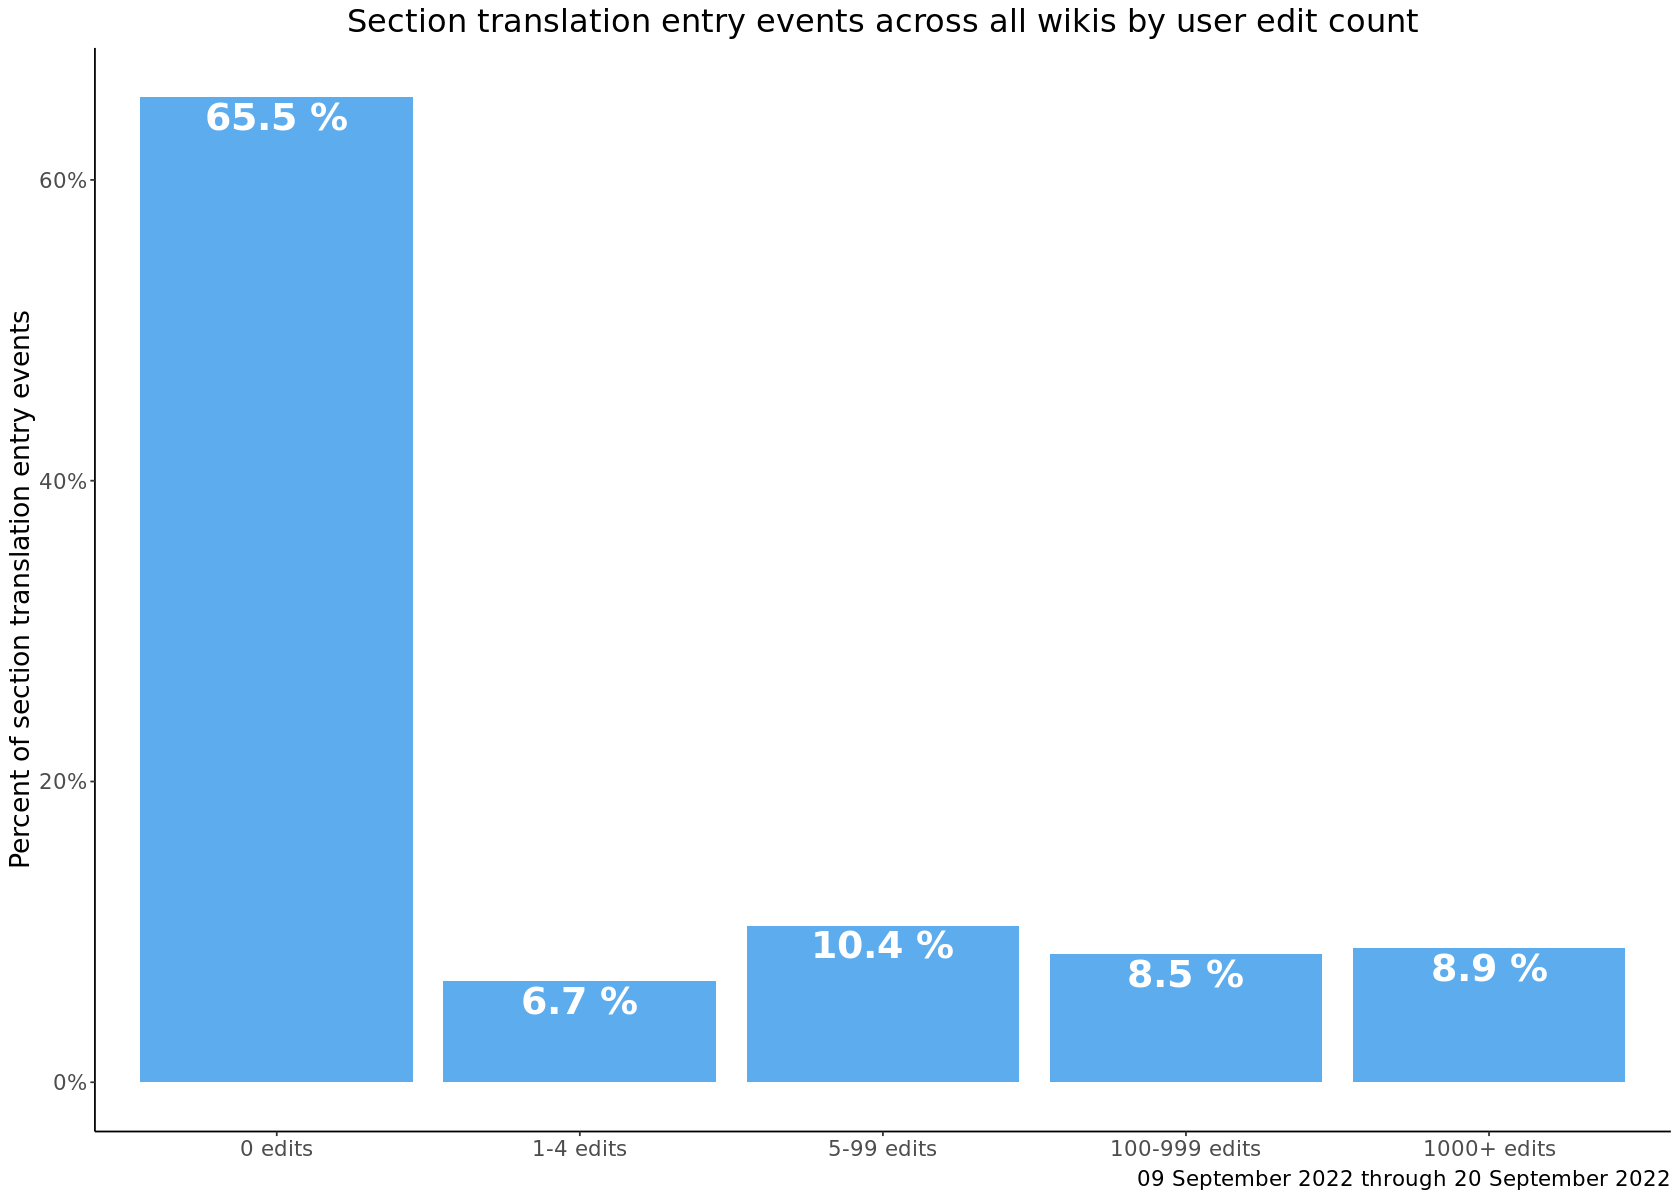

In [13]:
# plot frequency of events by type
options(repr.plot.width = 14, repr.plot.height = 10)

p <- sx_entry_event_byuserexp   %>%
    ggplot(aes(x= user_global_edit_count_bucket, y = pct_events)) +
    geom_col(position = 'dodge', fill = 'steelblue2') +
    geom_text(aes(label = paste(pct_events * 100, "%")), fontface=2, vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of section translation entry events",
          title = "Section translation entry events across all wikis by user edit count",
         caption = "09 September 2022 through 20 September 2022")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        axis.title.x=element_blank(),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/sx_entry_event_byuserexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [14]:
sx_entry_event_byuserexp_source <- sx_entry_events %>% 
    group_by(user_global_edit_count_bucket, event_source) %>%
    summarise(n_events = n(),
             n_users = n_distinct(user_name)) %>%
     mutate(pct_events = round(n_events / sum(n_events), 3),
           pct_users = round(n_users / sum(n_users), 3)) 

sx_entry_event_byuserexp_source


`summarise()` regrouping output by 'user_global_edit_count_bucket' (override with `.groups` argument)



user_global_edit_count_bucket event_source                n_events n_users
1  0 edits                       frequent_languages          8314     2440   
2  0 edits                       content_language_selector   2052      583   
3  0 edits                       direct                       800      456   
4  0 edits                       invite_new_article_creation  232       36   
5  0 edits                       direct_preselect              22        6   
6  1-4 edits                     frequent_languages           737      257   
7  1-4 edits                     content_language_selector    277       52   
8  1-4 edits                     direct                        99       48   
9  1-4 edits                     invite_new_article_creation   24       11   
10 1-4 edits                     direct_preselect              34       10   
11 5-99 edits                    frequent_languages          1248      401   
12 5-99 edits                    content_language_selector    219       43   
13 5-99 edits                    direct                       221       77   
14 5-99 edits                    invite_new_article_creation   42       13   
15 5-99 edits                    direct_preselect              79       16   
16 100-999 edits                 frequent_languages           812      208   
17 100-999 edits                 content_language_selector    178       19   
18 100-999 edits                 direct                       277       68   
19 100-999 edits                 invite_new_article_creation  114       11   
20 100-999 edits                 direct_preselect             104       24   
21 100-999 edits                 NA                             2        1   
22 1000+ edits                   frequent_languages           688      255   
23 1000+ edits                   content_language_selector    105       47   
24 1000+ edits                   direct                       431       89   
25 1000+ edits                   invite_new_article_creation  109       17   
26 1000+ edits                   direct_preselect             211       35   
27 1000+ edits                   NA                             2        1   
   pct_events pct_users
1  0.728      0.693    
2  0.180      0.166    
3  0.070      0.130    
4  0.020      0.010    
5  0.002      0.002    
6  0.629      0.680    
7  0.237      0.138    
8  0.085      0.127    
9  0.020      0.029    
10 0.029      0.026    
11 0.690      0.729    
12 0.121      0.078    
13 0.122      0.140    
14 0.023      0.024    
15 0.044      0.029    
16 0.546      0.628    
17 0.120      0.057    
18 0.186      0.205    
19 0.077      0.033    
20 0.070      0.073    
21 0.001      0.003    
22 0.445      0.574    
23 0.068      0.106    
24 0.279      0.200    
25 0.071      0.038    
26 0.136      0.079    
27 0.001      0.002

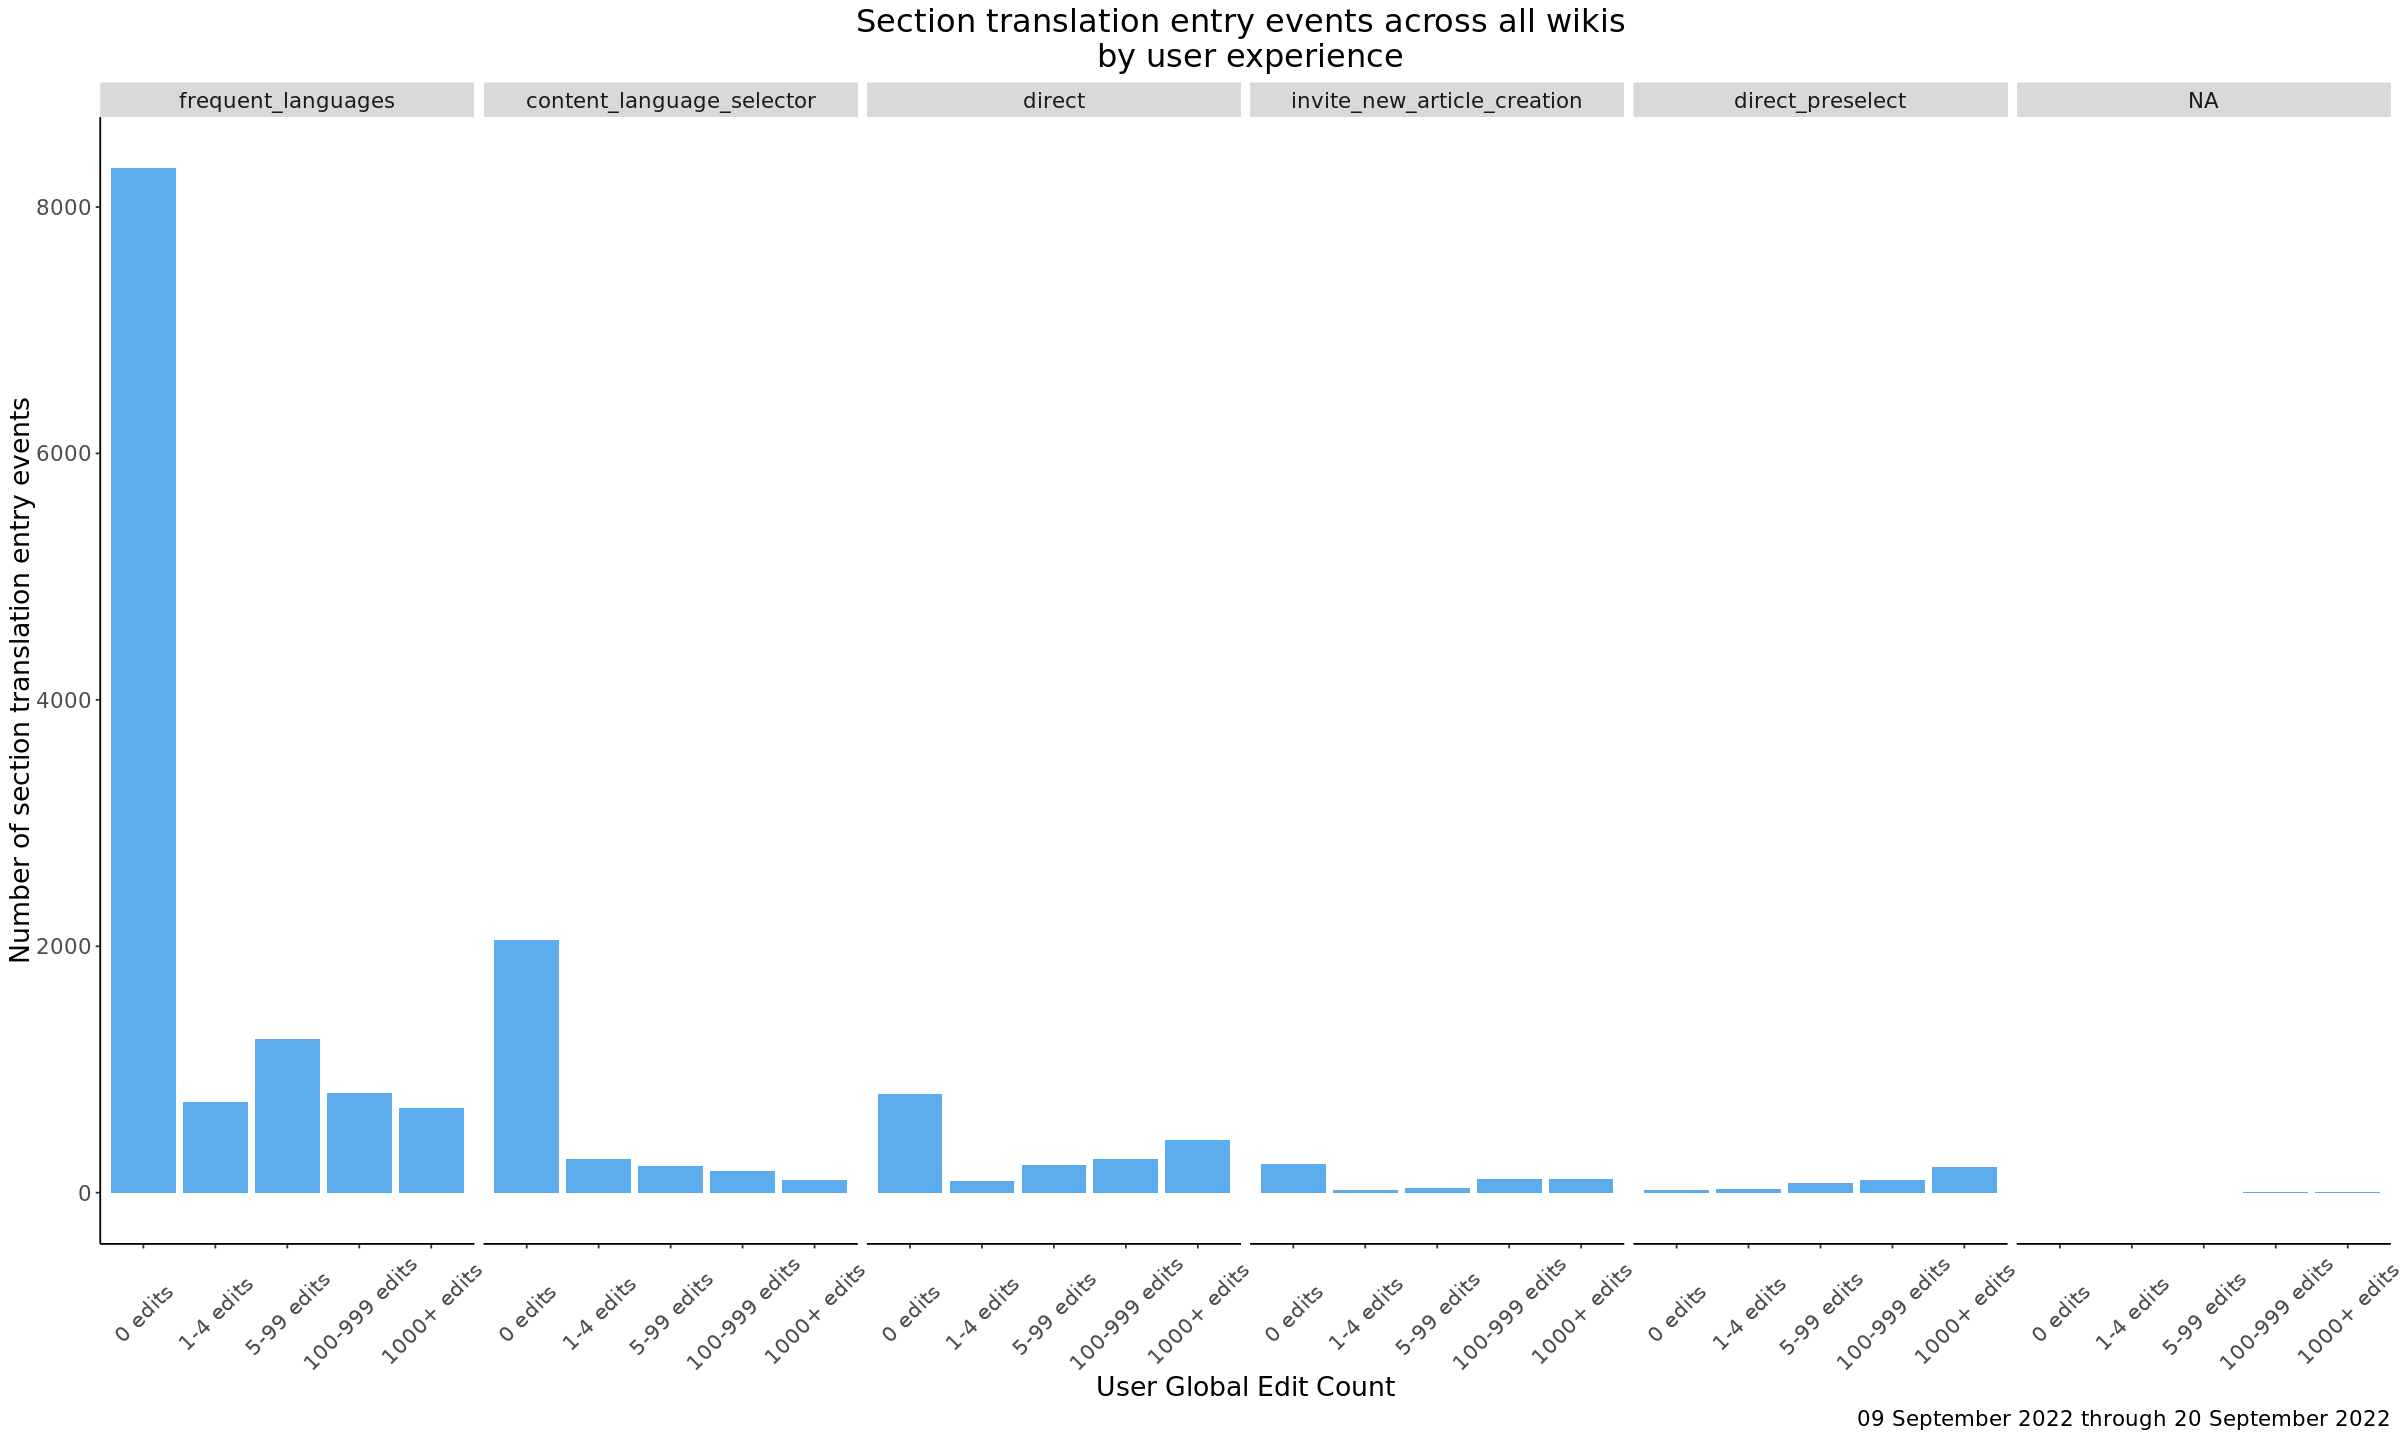

In [15]:
# plot events by user experience

options(repr.plot.width = 20, repr.plot.height = 12)

p <- sx_entry_event_byuserexp_source  %>%
    ggplot(aes(x= user_global_edit_count_bucket , y = n_events)) +
    geom_col(position = 'dodge', fill = 'steelblue2')+
    facet_grid(cols = vars(event_source))+
    scale_y_continuous() +
    labs (y = "Number of section translation entry events",
          x = "User Global Edit Count",
          title = "Section translation entry events across all wikis \n by user experience",
         caption = "09 September 2022 through 20 September 2022")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5),
        text = element_text(size=16),
        legend.position= "right",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/sx_entry_event_byuserexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

Findings:
* The majority of entry point events (68.4%) were completed by new editors logged as having 0 cumulative edits. This seems high and it would be interesting to determine what percent of these users end up publishing a translation, once publish events are instrumented.
* This trend also true when broken down by event source type except for the `direct_preselect` entry pont where more entry events were completed by experienced editors with over 1000+ cumulative edits.


# By Wiki DB

Notes: 
* Wiki DB in this analysis refers to the database code for the wiki which the user is currently interacting with (and which is shown in the current URL). This is less meaningful than usual because Content Translation presents a single, cross-wiki interface to the user. The target and source language fields would be more useful once added.

In [74]:
sx_entry_events_bywiki <- sx_entry_events %>% 
    group_by(wiki_db) %>%
    summarise(n_events = n(),
             n_users = n_distinct(user_name))  %>%
     mutate(pct_events = round(n_events / sum(n_events), 3)) %>%
    arrange(desc(n_events))


In [17]:
sx_entry_events_bywiki  %>% 
    summarise(n_wikis = n_distinct(wiki_db))

n_wikis
1 76

We have logged section entry events at 76 distinct wikis. 22 of these wikis had over 100 section translation events logged during the reviewed timeframe. I limited the by wiki analysis below to these wikis since they had a sufficient sample size to identify potential trends across the population.

In [18]:
# order target languages based on factor levels

lvls <- as.character(sx_entry_events_bywiki$wiki_db)[order(sx_entry_events_bywiki$n_events)]
sx_entry_events_bywiki$wiki_db<- factor(sx_entry_events_bywiki$wiki_db,levels=lvls)

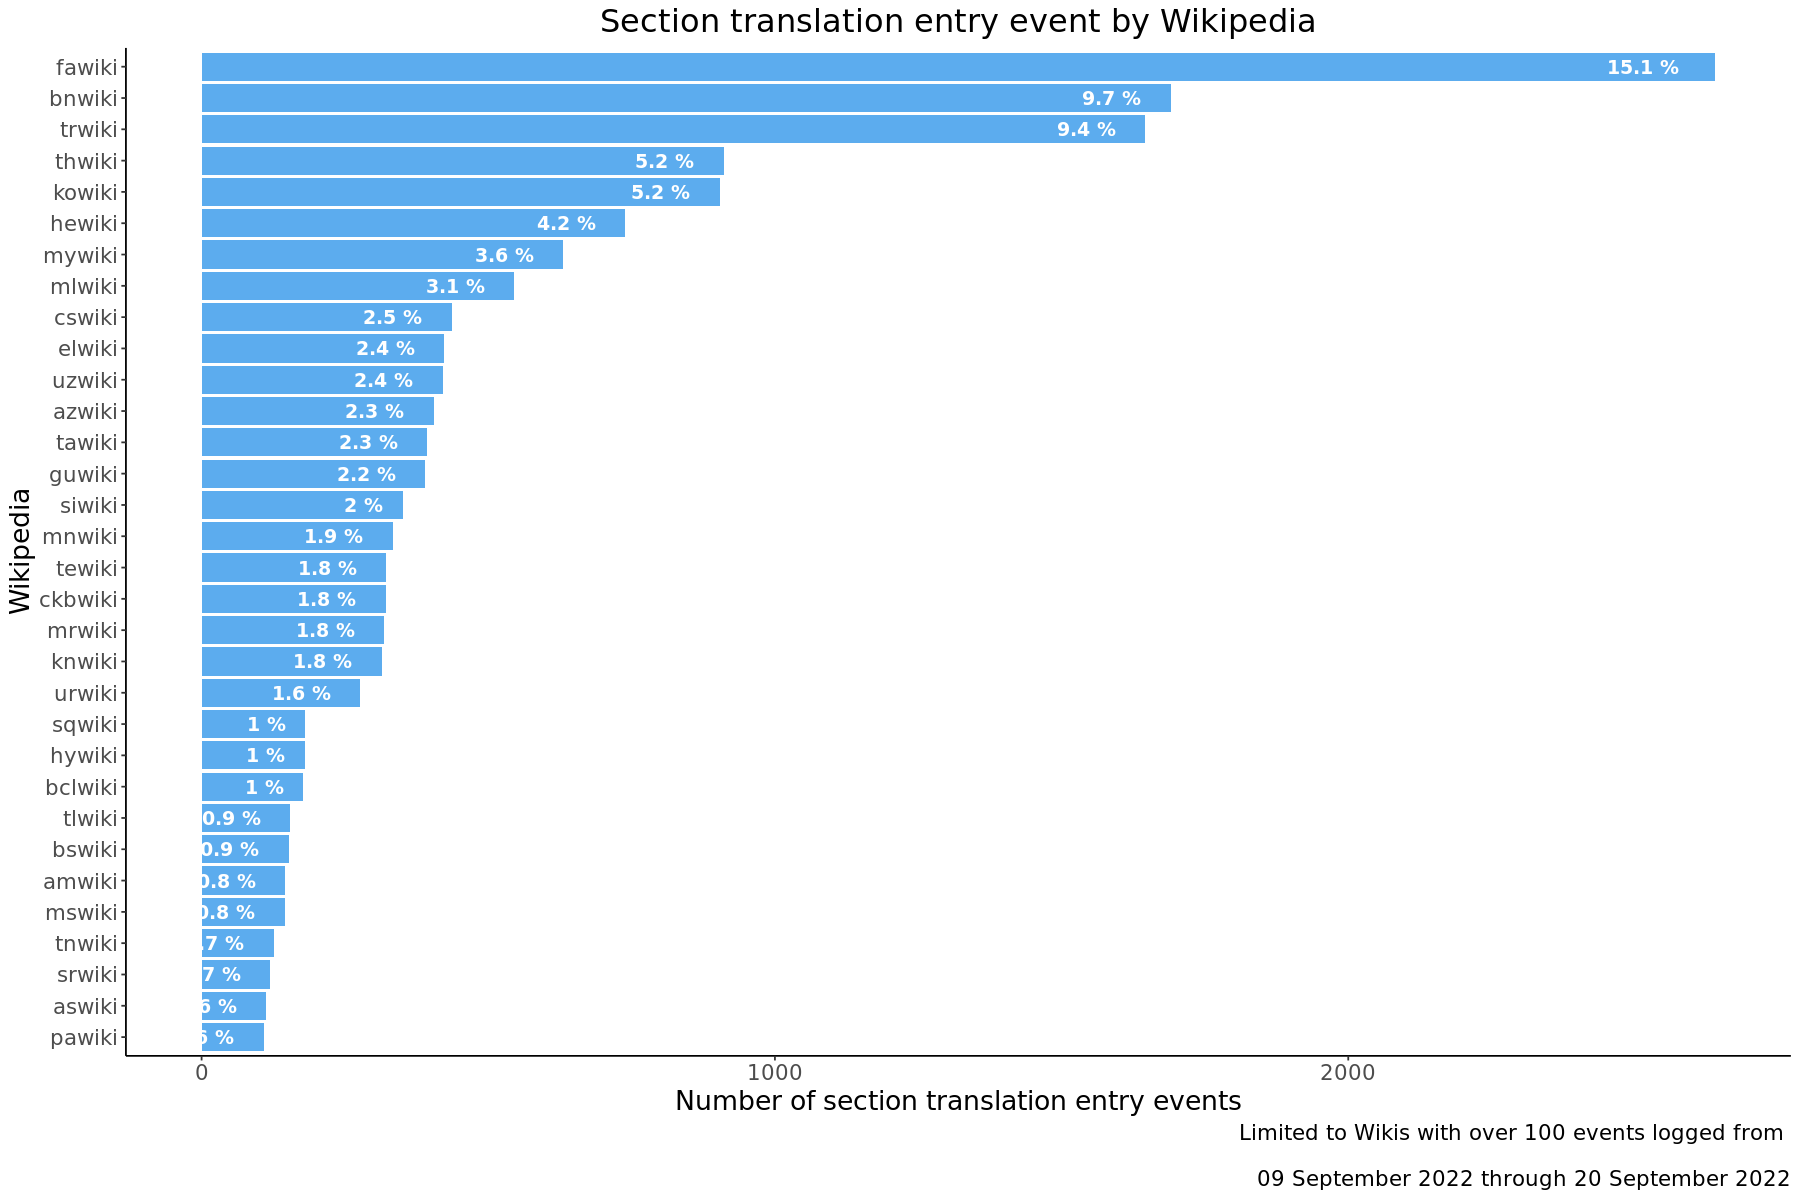

In [19]:
# plot events by wiki

options(repr.plot.width = 15, repr.plot.height = 10)

p <- sx_entry_events_bywiki  %>%
    filter(n_events > 100) %>%
    #top_n(n=10)  %>% # select top 10 wikis
    ggplot(aes(x= wiki_db, y = n_events)) +
    geom_col(position = 'dodge', fill = 'steelblue2') +
    coord_flip()+
    geom_text(aes(label = paste(pct_events * 100, "%"), fontface=2), hjust= 1.5, size = 4, color = "white") +
    scale_y_continuous() +
    labs (y = "Number of section translation entry events",
          x = "Wikipedia",
          title = "Section translation entry event by Wikipedia" ,
         caption = "Limited to Wikis with over 100 events logged from \n
                    09 September 2022 through 20 September 2022")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/sx_entry_events_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)



Persian Wikipedia (fawiki) has the most logged section translations entry point events (15.1%) followed by Bengali (bnwiki) and Turkish (trwiki) Wikipedias.  

In [75]:
sx_entry_events_bywiki_daily <- sx_entry_events %>% 
    group_by(date, wiki_db) %>%
    summarise(n_events = n())  %>%
    arrange(desc(n_events))

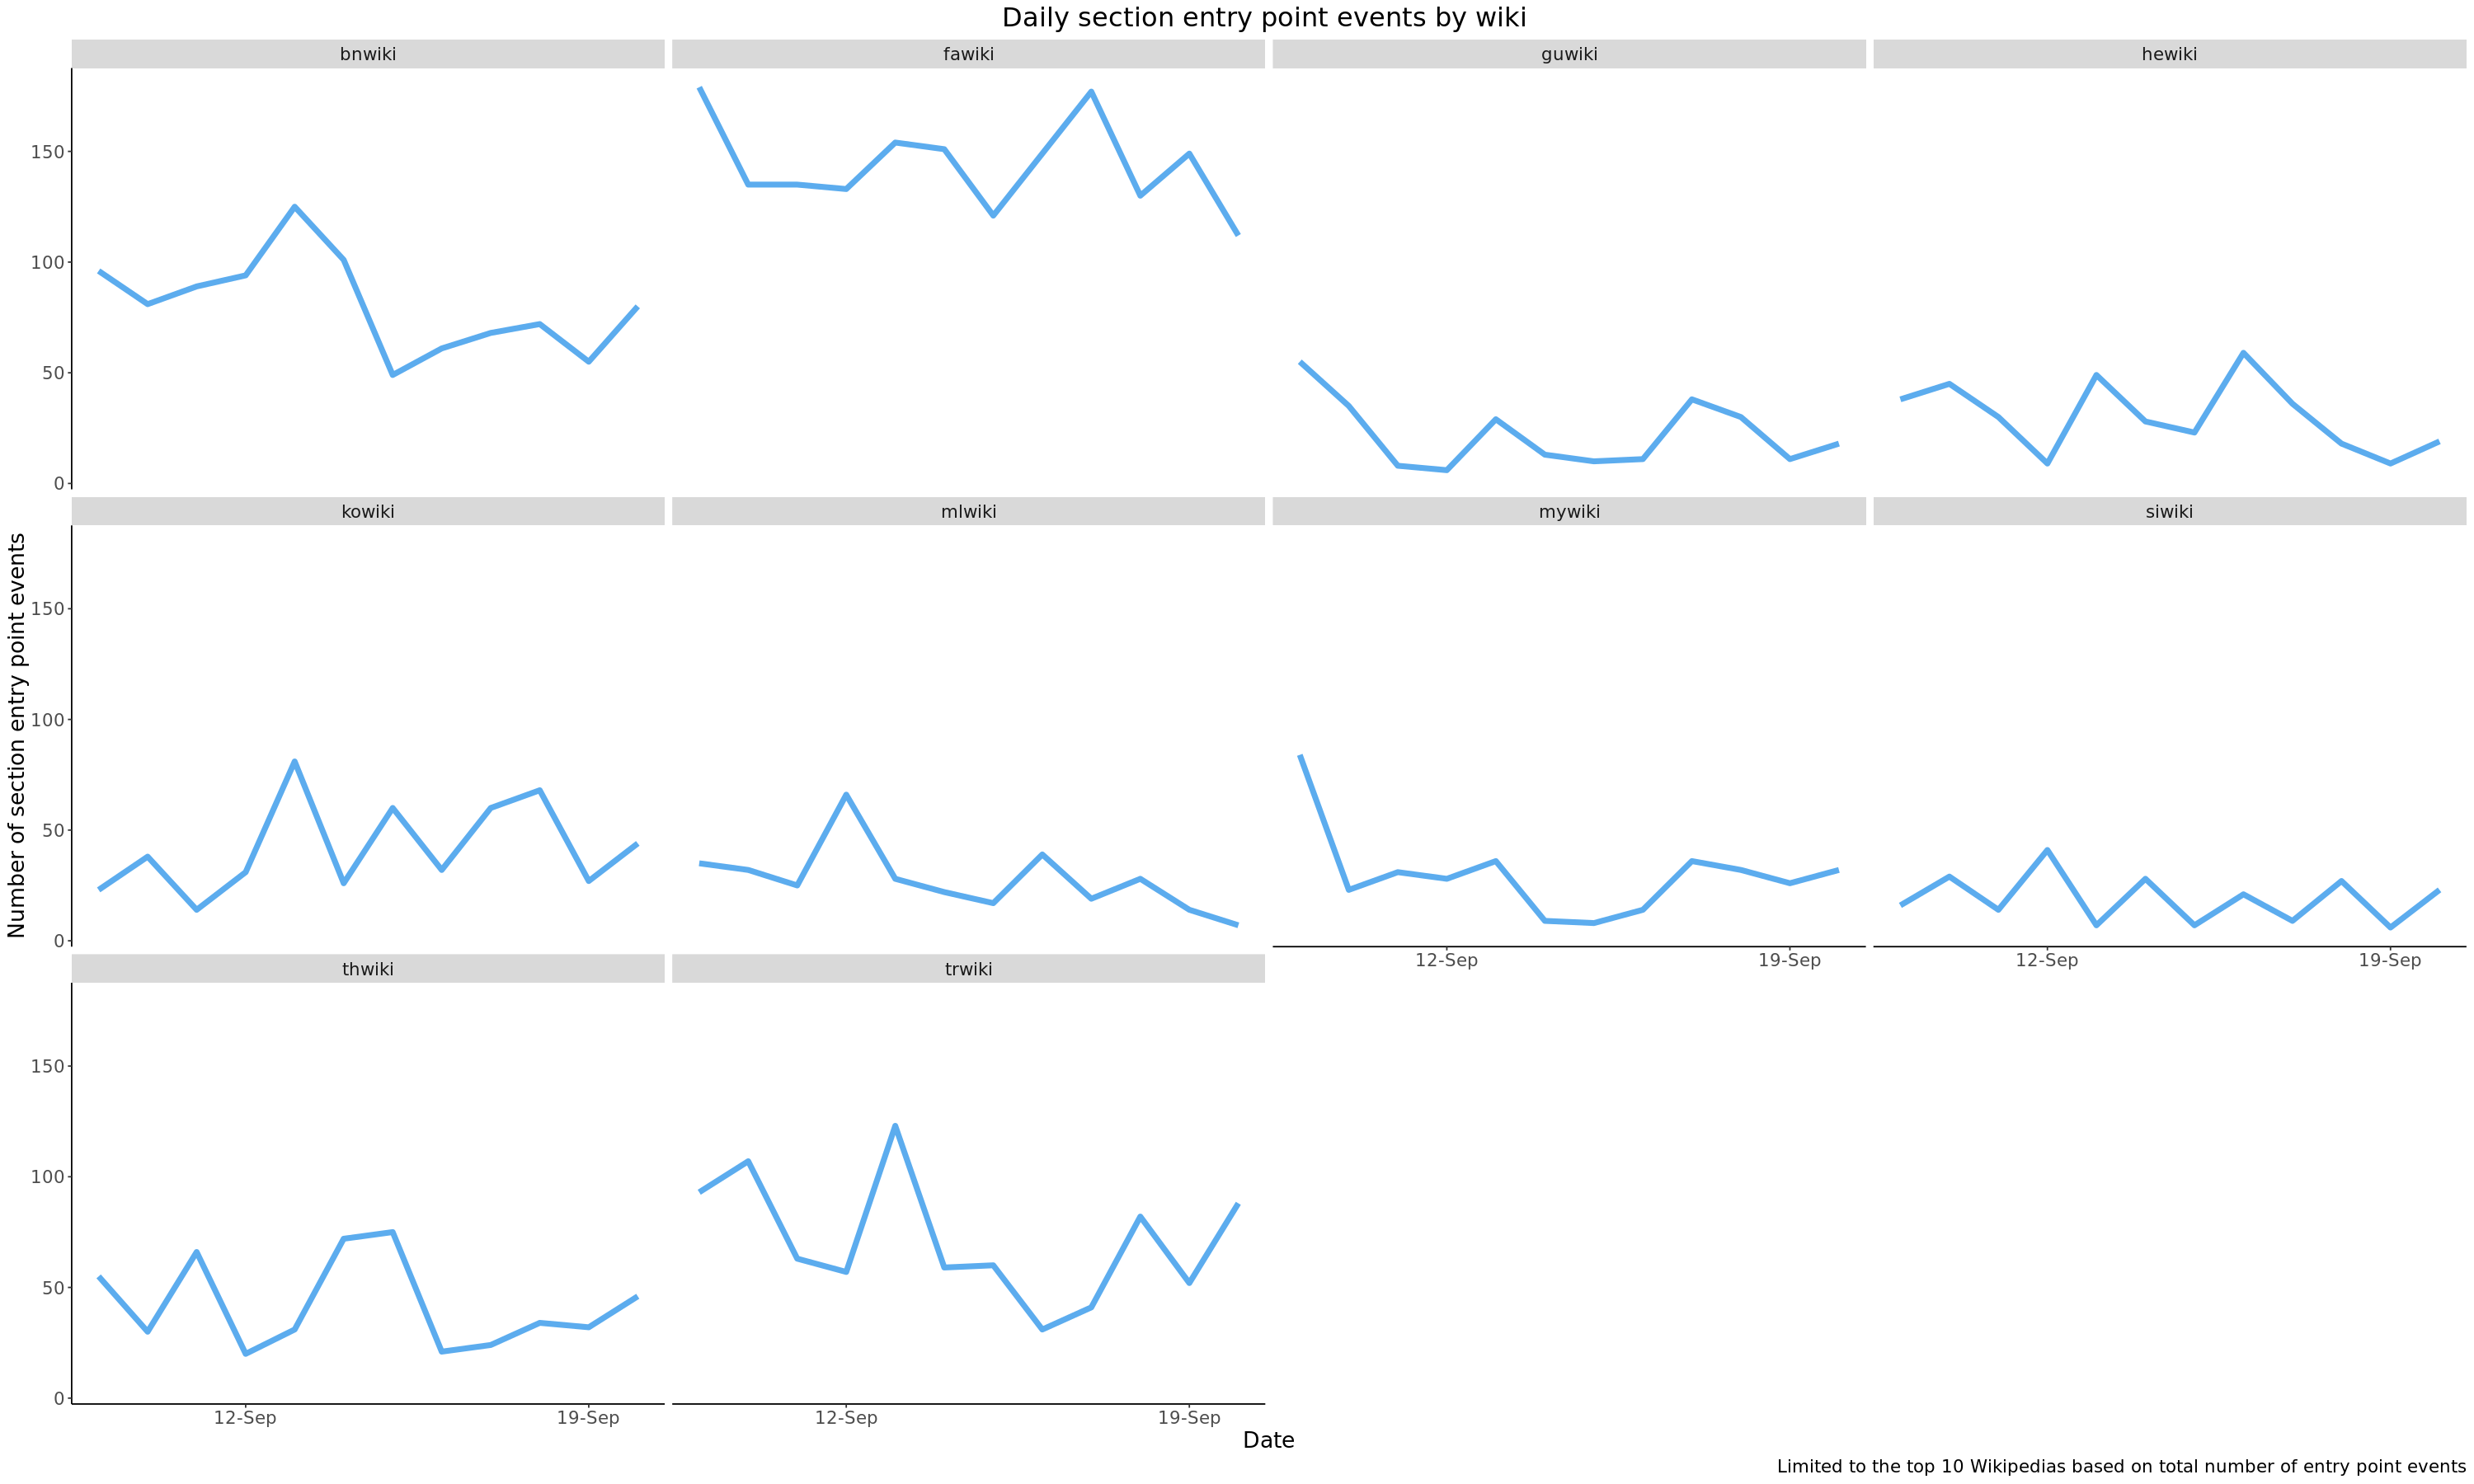

In [76]:
# plot by wiki
p <- sx_entry_events_bywiki_daily %>%
    filter(date >= '2022-09-09' &
          date <= '2022-09-20',
          wiki_db %in% c('fawiki', 'bnwiki', 'trwiki', 'thwiki', 'kowiki',
                        'hewiki', 'mywiki', 'mlwiki', 'guwiki' , 'siwiki'))  %>%  #Wikipedia where entry points most fequently used
    ggplot(aes(x= date, y = n_events)) +
    geom_line(size = 2, color = 'steelblue2') +
    facet_wrap(~ wiki_db) +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
    scale_y_continuous() +
    labs (y = "Number of section entry point events",
          x = "Date",
         title = "Daily section entry point events by wiki ", 
         caption = "Limited to the top 10 Wikipedias based on total number of entry point events") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black"))    

p

ggsave("Figures/sx_entry_events_bywiki_daily.png", p, width = 16, height = 11, units = "in", dpi = 300)

A review of daily events for each of the identifed top Wikipedias do not show any significant spikes or drops in usage indicating that daily entry point use remains stable across each of the Wikis.

### By Wikipedia and event source type

In [77]:
sx_entry_events_bywiki_type <- sx_entry_events %>%
   filter(wiki_db %in% c('fawiki', 'bnwiki', 'trwiki', 'thwiki', 'kowiki',
                        'hewiki', 'mywiki', 'mlwiki', 'guwiki' , 'siwiki', 
                        'tawiki', 'mnwiki', 'tewiki', 'elwiki', 'cswiki',
                        'azwiki', 'ckbwiki', 'mrwiki', 'knwiki', 'uzwiki',
                        'urwiki', 'tnwiki'))  %>%  
    group_by(wiki_db, event_source) %>%
    summarise(n_events = n(),
             n_users = n_distinct(user_name))  %>%
     mutate(pct_events = round(n_events / sum(n_events), 3)) 

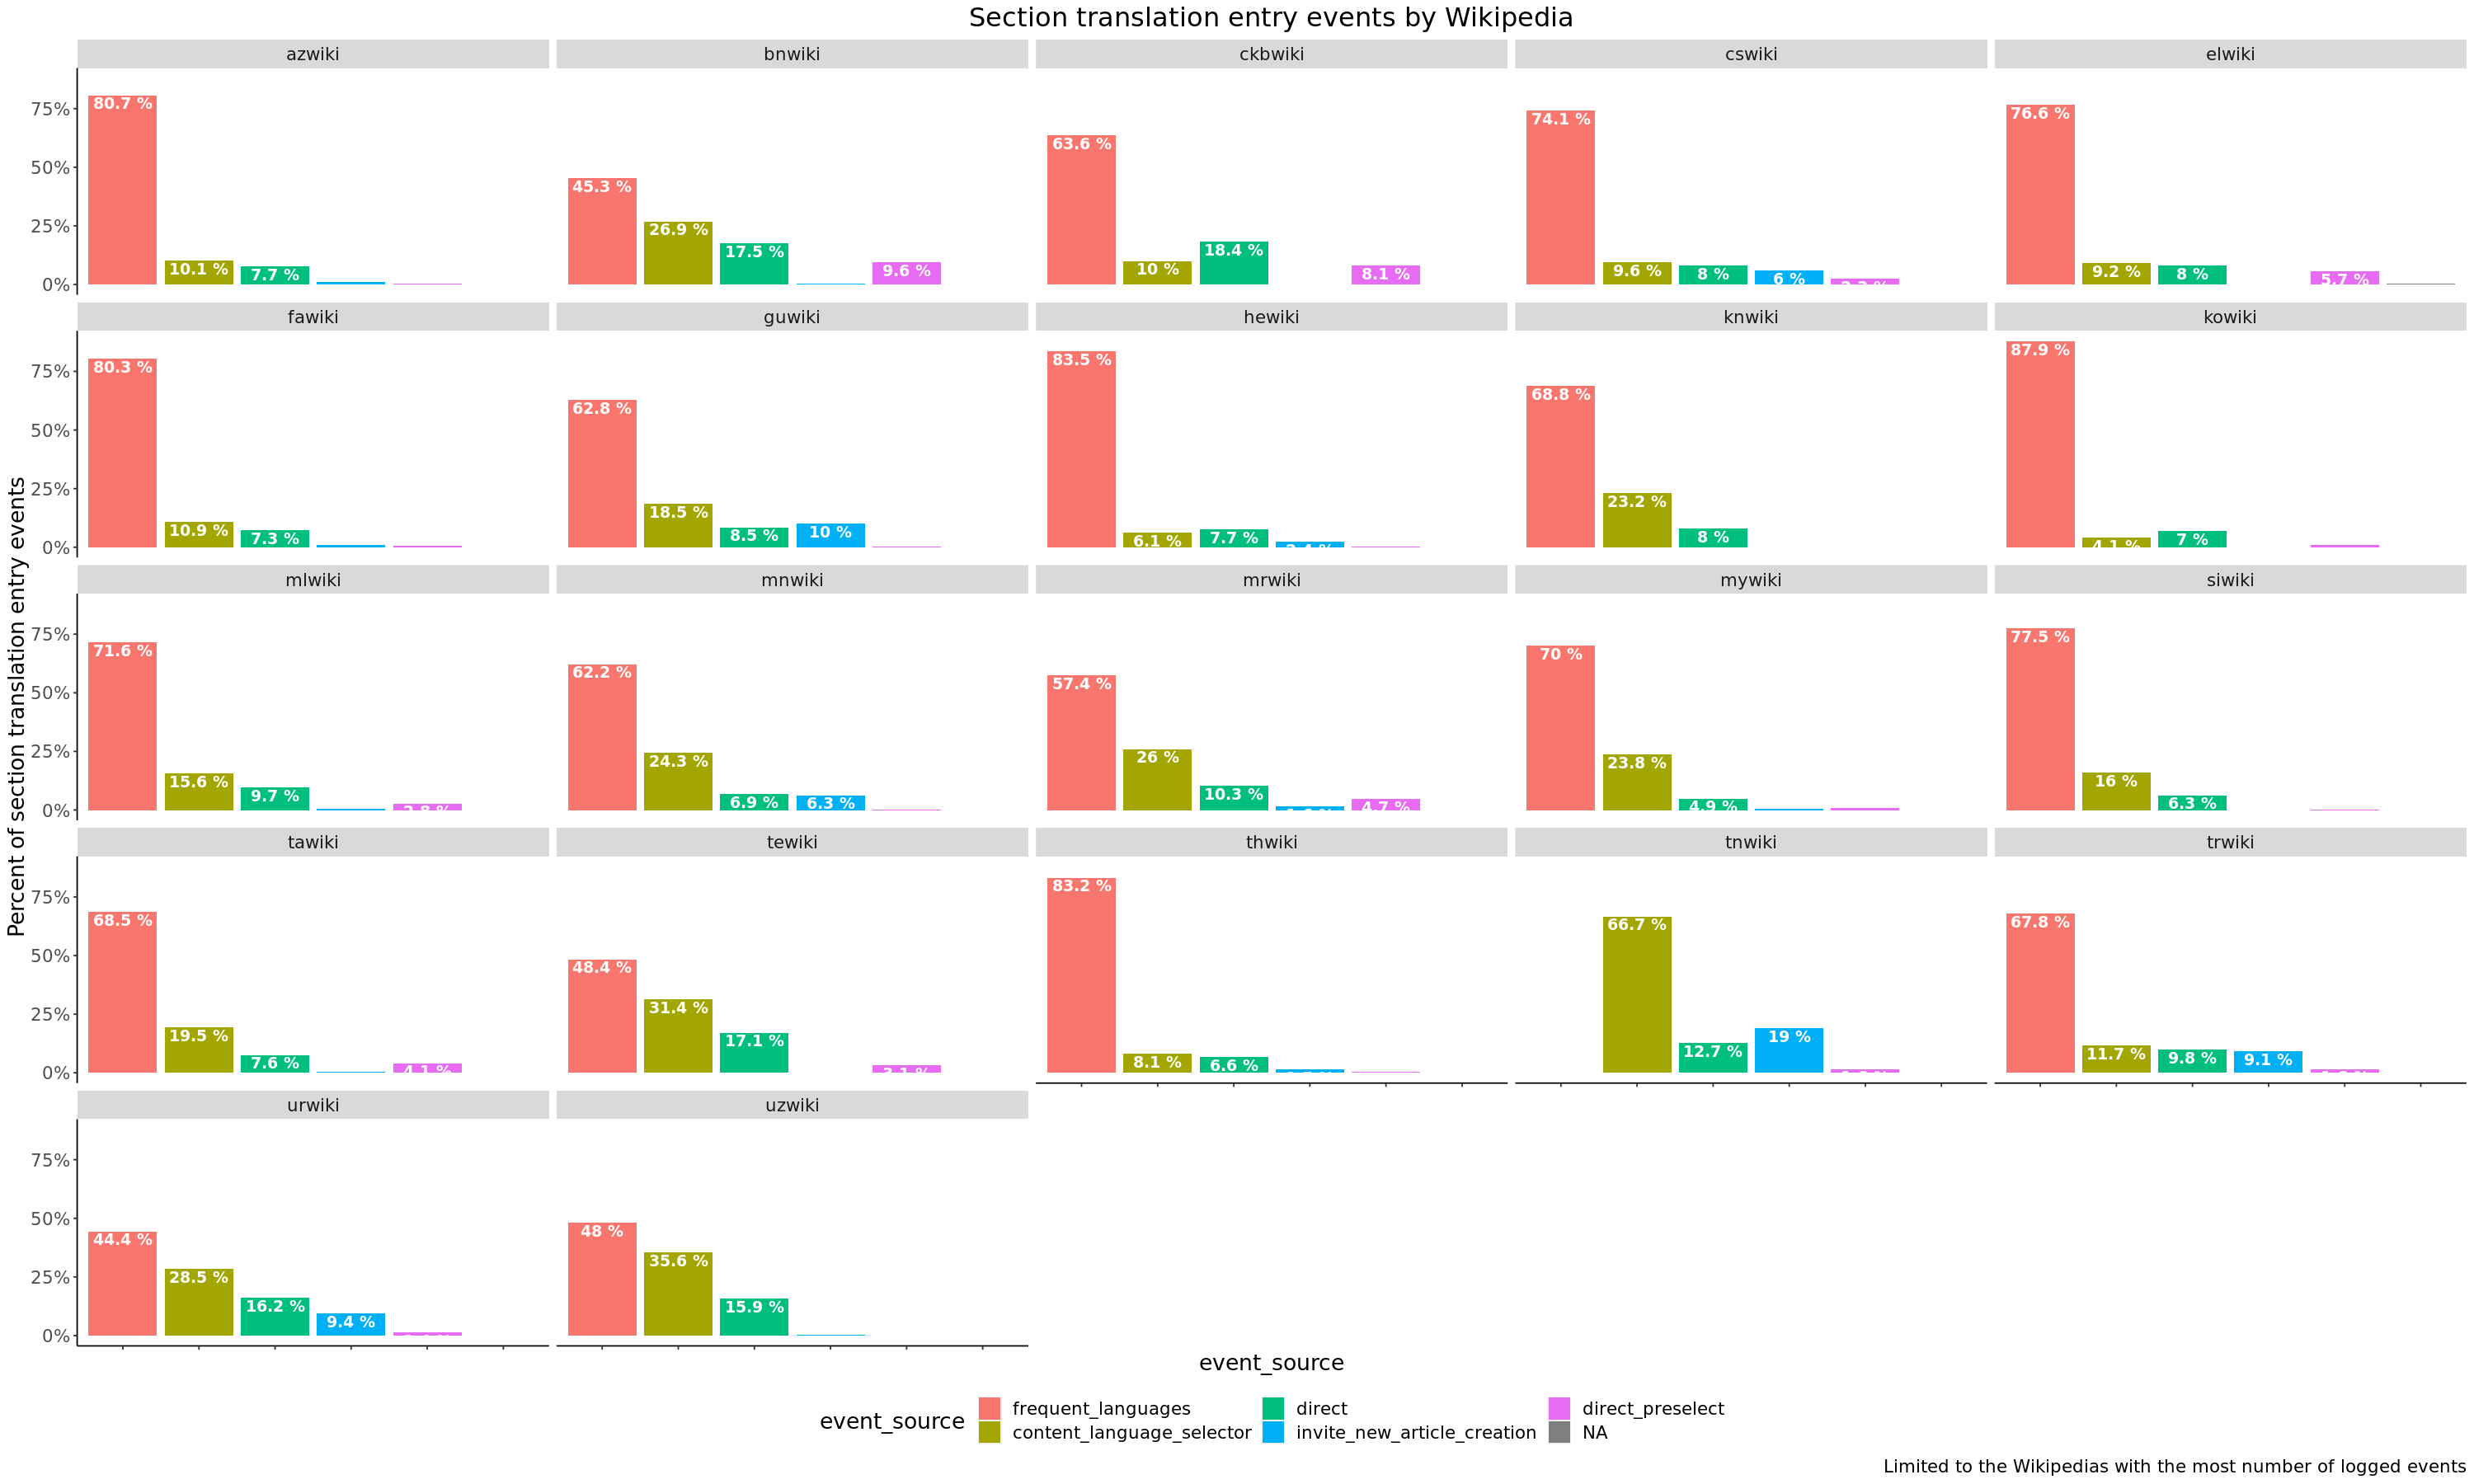

In [23]:
# plot frequency of events by type
options(repr.plot.width = 25, repr.plot.height = 15)

p <- sx_entry_events_bywiki_type  %>%
    ggplot(aes(x= event_source, y = pct_events, fill = event_source)) +
    geom_col(position = 'dodge') +
    facet_wrap(~ wiki_db) +
    geom_text(aes(label = paste(pct_events * 100, "%")), fontface=2, vjust=1.2, size = 4, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of section translation entry events",
          title = "Section translation entry events by Wikipedia",
         caption = "Limited to the Wikipedias with the most number of logged events")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x=element_blank(),
        legend.position= "bottom",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/sx_entry_events_bywiki_type .png", p, width = 16, height = 8, units = "in", dpi = 300)

Key Findings:
* Frequent_langauges is the most used entry point across all Wikipedias identifed as having the most logged section translation entry points, except for Tswana (tnwiki) where no frequent_languages events were logged. 
* Bengali Wikipedia (bnwiki)  and Burmese (mywiki) has the higher percent usage of the content language selector entry point (27.8% and 28.5% respectively)
* Bengali Wikipedia (bnwiki) had the highest usage of the direct_preselect entry point (11.1% compared to under 5% at other reviewed Wikipedias).
* Bengali Wikipedia also had the lowest usage of the frequently languages entry point (41.5% of all section translation events at this Wiki compared to over 50% at others). 

# Events by Session

For each events, we also log the `content_translation_session_id`: A unique, cross-wiki ID for a particular session of Content Translation activity.Expires  after 15 minutes has passed without the user generating an event in this stream.

I reviewed the number of events logged in each content translation session to understand how many entry point clicks are typical within a single session. 

In [105]:
sx_entry_events_bysession <- sx_entry_events %>%
    group_by(content_translation_session_id) %>%
    summarise(n_events = n())  %>%
# group outliers together
    mutate(event_group = ifelse(n_events > 20, "over 20", n_events))  %>%
    group_by(event_group) %>%
    summarise(n = n()) %>%
  mutate(pct_events = round(n/sum(n), 3))

In [106]:
# set factor levels
sx_entry_events_bysession$event_group = 
  factor(sx_entry_events_bysession$event_group, 
levels = c("1", "2", "3", "4", "5","6","7","8","9","10","11","12","13",
           "14","15","16","17","18","19","20","over 20"))


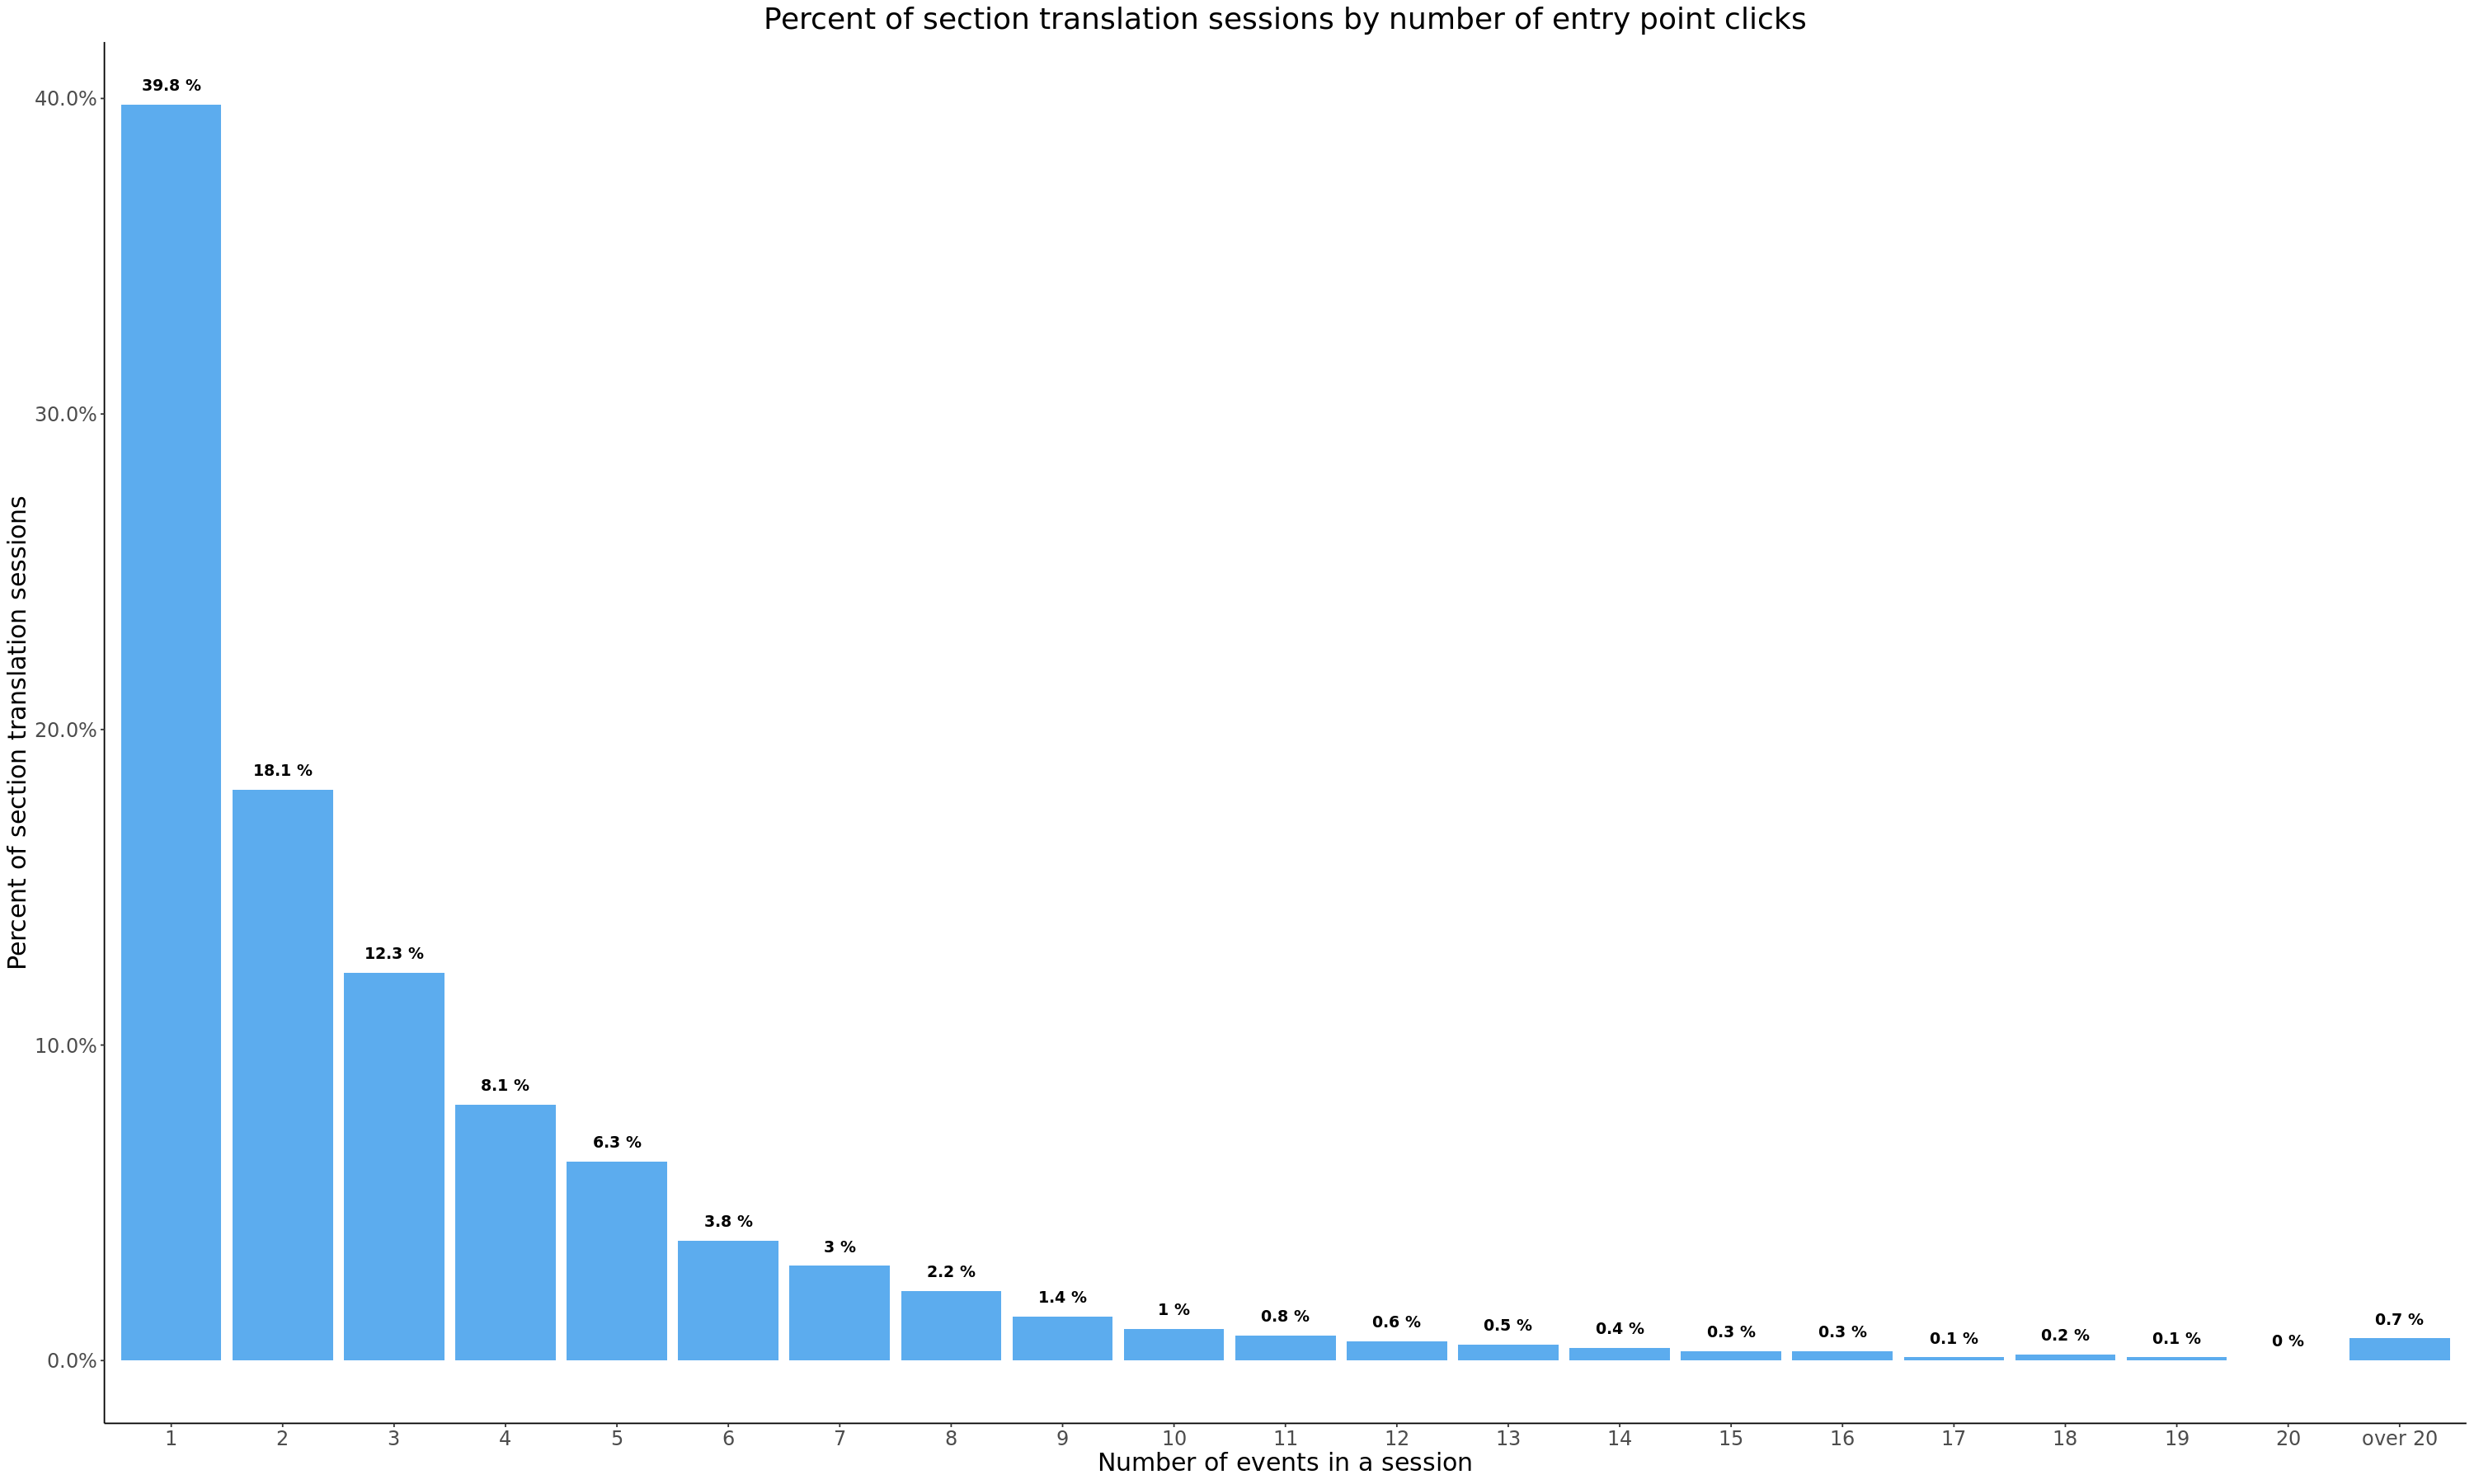

In [107]:
p <- sx_entry_events_bysession %>%
    ggplot(aes(x = event_group, y = pct_events)) +
    geom_col(fill = 'steelblue2') +
     scale_y_continuous(labels = scales::percent) +
     geom_text(aes(label = paste(pct_events * 100, "%")), fontface=2, vjust=-1.2, size = 4, color = "black") +
    labs (y = "Percent of section translation sessions",
          x = "Number of events in a session",
          title = "Percent of section translation sessions by number of entry point clicks")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position= "bottom",
        axis.line = element_line(colour = "black")) 
 
p

ggsave("Figures/sx_entry_events_bysession.png", p, width = 16, height = 8, units = "in", dpi = 300)

About 40% of sessions include 1 entry event click and 18% of sessions include 2 clicks. As expected, the percent of sessions continues to decrease as the number of events in a session increase.

There are a small percent (under 1%) of highly active sessions with over 20 events per session.

# Sessions by User

We also reviewed the typical number of sessions per user to understand what percentage of users accessing the  translation tool are recurring vs just one-time users.

Note: I recommend looking at sessions per user vs events as it provides a better understanding of how many times the user is accessing the tool as it possible for a user to make many clicks (events) in a single session with the tool. 


In [108]:
sx_entry_sessions_byusers <- sx_entry_events %>%
    group_by(user_name) %>%
    summarise(n_sessions = n_distinct(content_translation_session_id))  %>%
# group outliers together
    mutate(session_group = ifelse(n_sessions > 15, "over 15", n_sessions))  %>%
    group_by(session_group) %>%
    summarise(n = n()) %>%
  mutate(pct_sessions = round(n/sum(n), 3),)

In [109]:
# set factor levels
sx_entry_sessions_byusers$session_group = 
  factor(sx_entry_sessions_byusers$session_group, 
levels = c("1", "2", "3", "4", "5","6","7","8","9","10","11","12","13",
           "14","15", "over 15"))

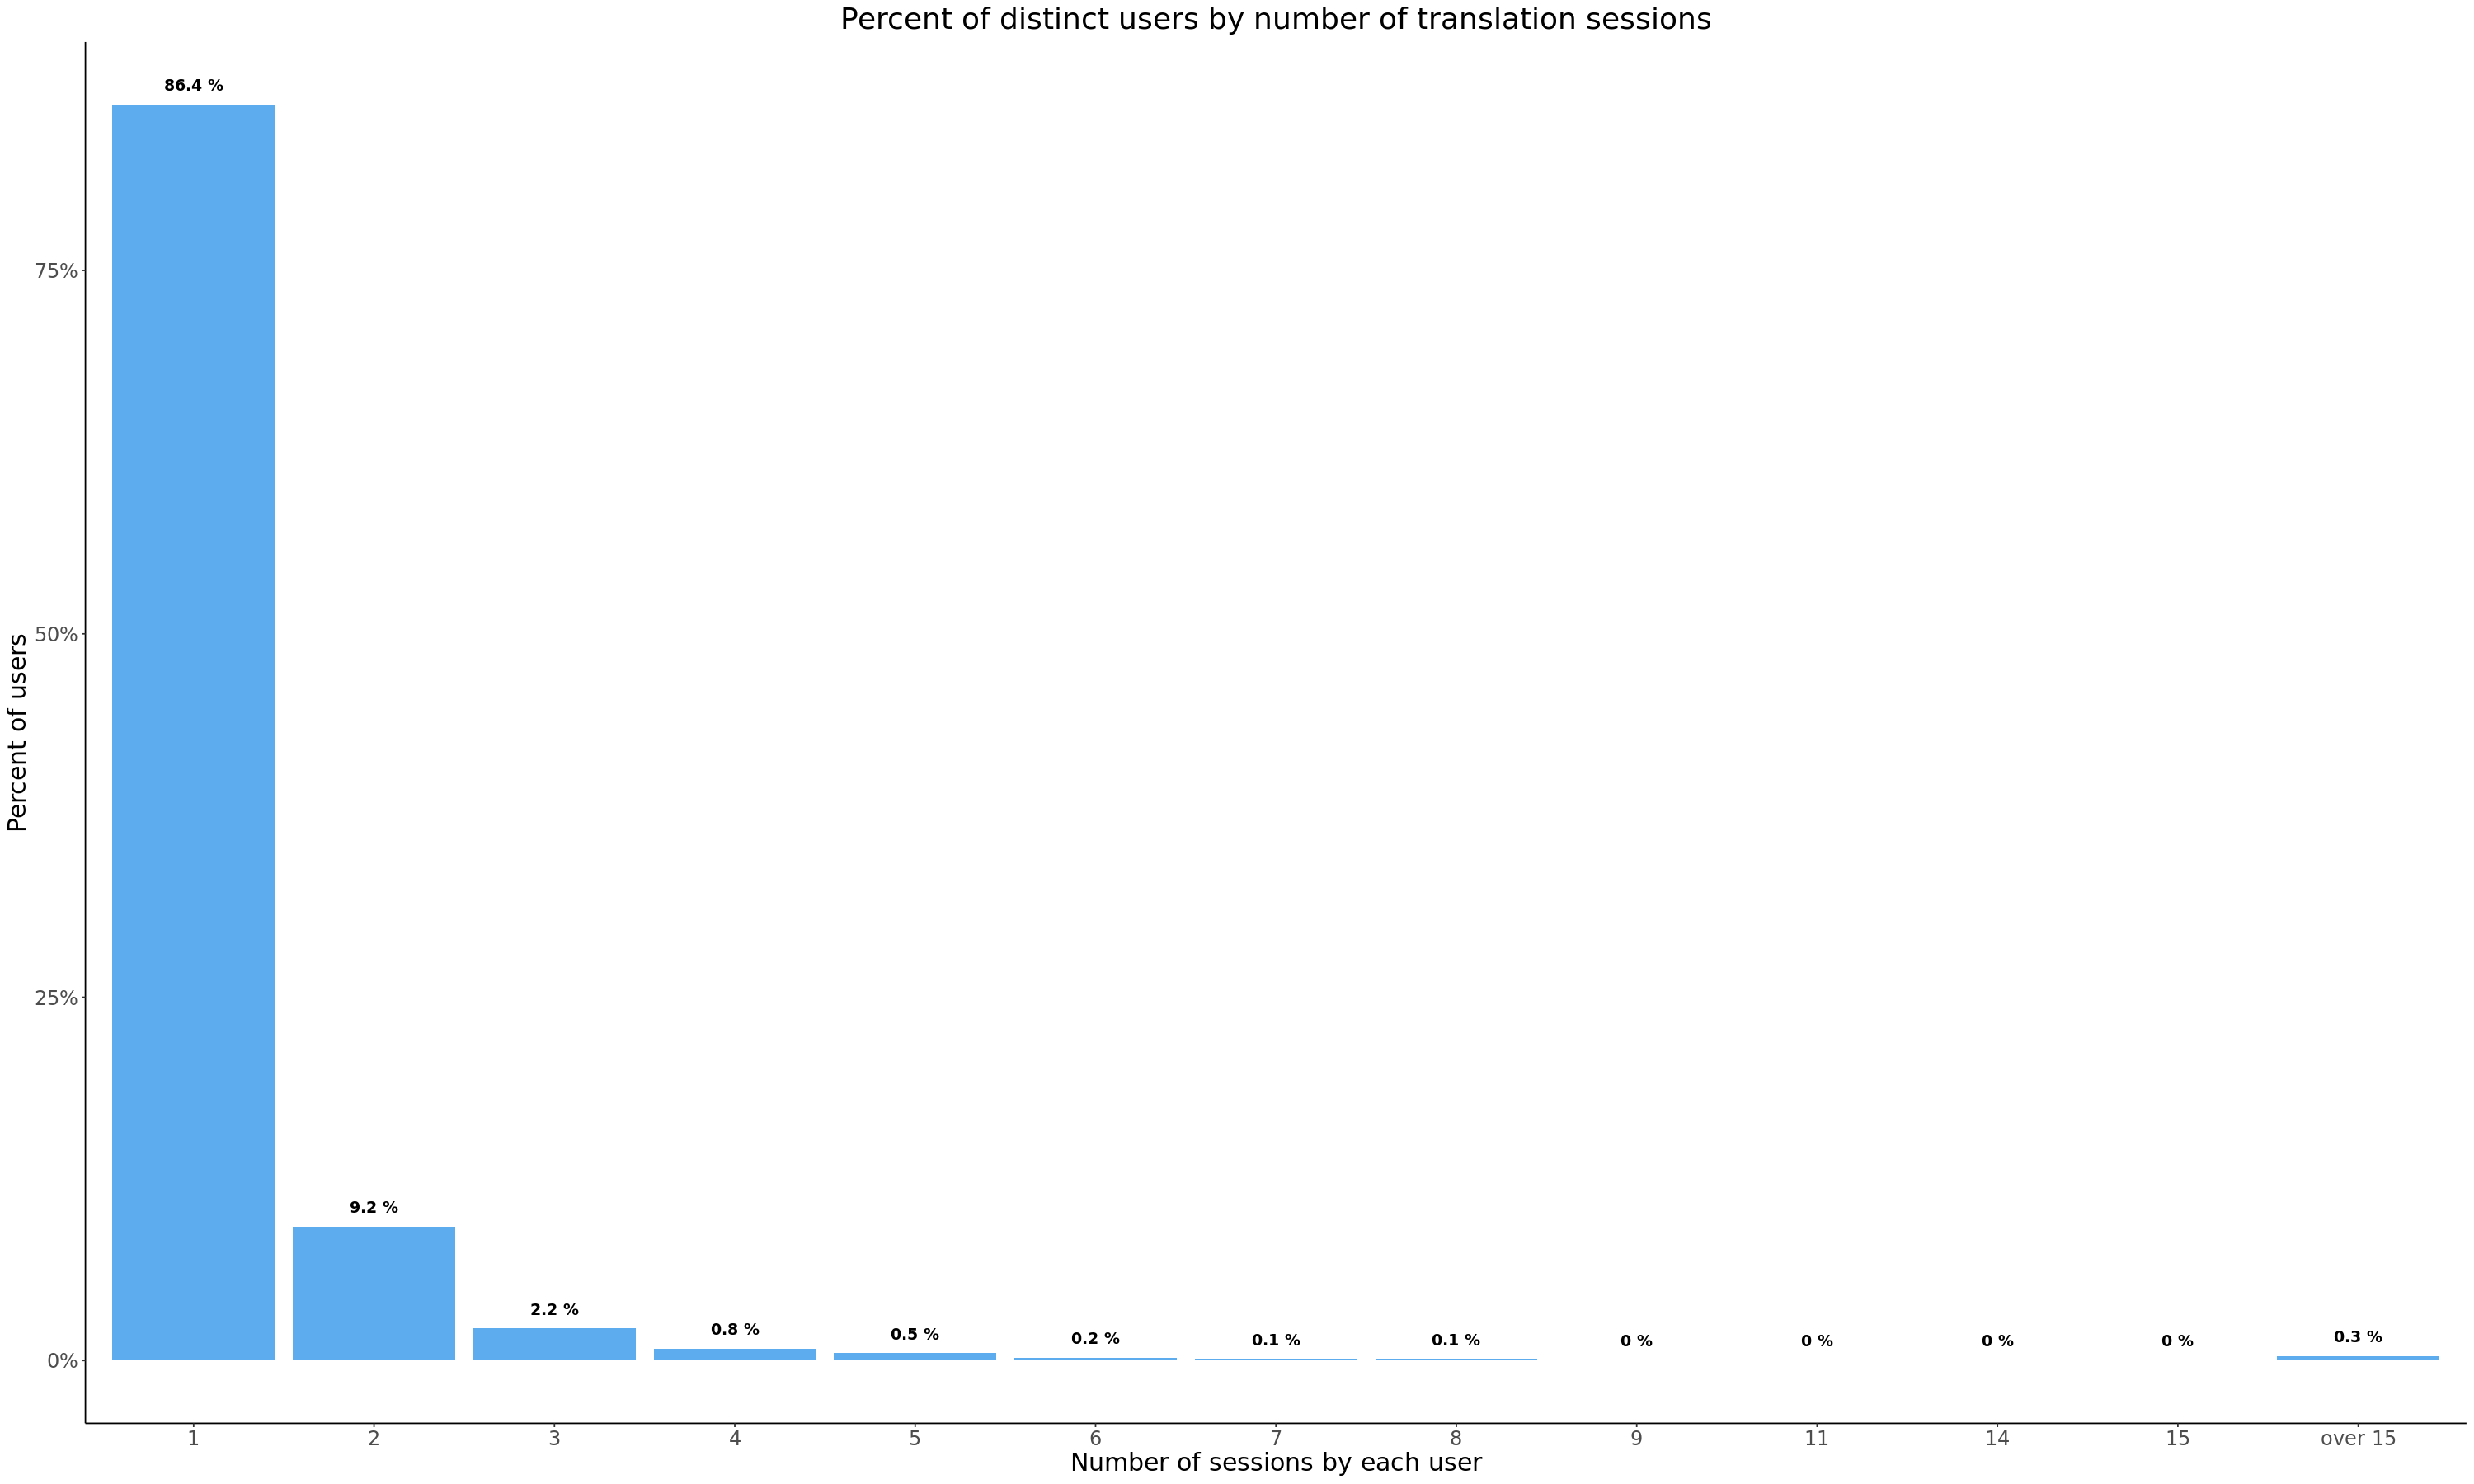

In [111]:
p <- sx_entry_sessions_byusers %>%
    ggplot(aes(x = session_group, y = pct_sessions)) +
    geom_col(fill = 'steelblue2') +
     scale_y_continuous(labels = scales::percent) +
     geom_text(aes(label = paste(pct_sessions * 100, "%")), fontface=2, vjust=-1.2, size = 4, color = "black") +
    labs (y = "Percent of users",
          x = "Number of sessions by each user",
          title = "Percent of distinct users by number of translation sessions")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position= "bottom",
        axis.line = element_line(colour = "black")) 
 
p

ggsave("Figures/sx_entry_sessions_byusers.png", p, width = 16, height = 8, units = "in", dpi = 300)

The majority of users (86.4%) have had just 1 recorded content translation session during the reviewed time period.  This is a short time frame and it is likely we may see more recurring users after we collect data for a longer period of time.

Next Steps:
* Further instrumentation of the content_translation_event schema including all editor and publish events would help us further understand the user's interfaction with section and content translation from start to finish.  